In [2]:
import os
import numpy as np
from PIL import Image , ImageOps
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import h5py
from sklearn.model_selection import train_test_split
import random
import keras
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

%matplotlib inline
np.random.seed(123)

/anaconda3/envs/aiscope/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
def model_test(dir_img_True = '../data pre processing/croped data/malaria/',dir_img_False = '../data pre processing/croped data/no malaria/', weights_file = './model_weights.h5' , img_rows = 40 , img_cols = 40, num_images = 20, print_metrics_threshold = True , threshold = 5, plot_figures = True):

    counter = 0
    malaria = []
    no_malaria = []
    dataset_x = []
    dataset_y = []

    # Load images malaria
    malaria_c=0
    no_malaria_c=0
    for file in os.listdir(dir_img_True):
        if file.endswith('.jpg'):
            img = mpimg.pil_to_array(Image.open(dir_img_True+file))
            if img.shape[0] == 40 and img.shape[1] == 40:
                malaria.append([img[:,:,0].reshape(40,40,-1)])
                malaria_c += 1


    # Load images no malaria
    for file in os.listdir(dir_img_False):
        if file.endswith('.jpg'):
            img = mpimg.pil_to_array(Image.open(dir_img_False+file))
            if img.shape[0] == 40 and img.shape[1] == 40:
                no_malaria.append([img[:,:,0].reshape(40,40,-1)])  
                no_malaria_c+=1
    print('malaria: ',malaria_c)
    print('no_malaria: ',no_malaria_c)




    # Image preprocessing to array
    malaria = np.asarray(malaria)
    no_malaria = np.asarray(no_malaria)
    malaria = malaria.reshape(malaria.shape[0],40,40,-1)
    no_malaria = no_malaria.reshape(no_malaria.shape[0],40,40,-1)
    malaria_y = np.ones((malaria.shape[0],1)).reshape(malaria.shape[0],)
    no_malaria_y = np.zeros((no_malaria.shape[0],1)).reshape(no_malaria.shape[0],)
    dataset_x = np.concatenate((malaria, no_malaria), axis=0)
    dataset_y = np.concatenate((malaria_y, no_malaria_y), axis=0)

    #Split into train and test
    x_train, x_test, y_train, y_test = train_test_split(dataset_x, dataset_y, test_size=0.33, random_state=42)

    # Load CNN

    num_classes = 2
    input_shape = (img_rows, img_cols, 1)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    # CNN structure
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    # model reconstruction from JSON:
    #test here https://machinelearningmastery.com/save-load-keras-deep-learning-models/
    #from keras.models import model_from_json
    #model = model_from_json(weights_file[:-3]+'.json')
    
    # Load model
    model.load_weights(weights_file)

    #Print scores
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    # print immages with predictions
    predictions = model.predict(x_test)
    images_and_predictions = list(zip(x_test, predictions, y_test))
    mistake_counter = 0

    from pylab import rcParams
    rcParams['figure.figsize'] = 20,100

    for i in range(0,num_images):
        actual_index = random.randint(1, len(x_test))
        if int(round(images_and_predictions[actual_index][1][1])) != int(images_and_predictions[actual_index][2][1]):
            mistake_counter +=1
        plt.subplot(4*num_images/4,4,i+1)
        plt.axis('off')
        plt.imshow(images_and_predictions[actual_index][0].reshape(40,40), interpolation='nearest')
        plt.title(' %i p: %i , r: %i ' %  (actual_index,round(images_and_predictions[actual_index][1][1]),images_and_predictions[actual_index][2][1]), fontsize=30)
    print('num fallos: ',mistake_counter)    
    print('acc: ',1-mistake_counter/num_images)
    plt.show()
    # Metrics depending of the threshold
    scatter_data=[]
    for x in range(0,1006,threshold):
        i = x/1000
        temp_pred = []
        true_pos = 0
        false_pos = 0
        true_neg = 0
        false_neg = 0
        temp_pred = predictions.copy() 
        #round values depending on the threshold
        temp_pred[:,1:2][temp_pred[:,1:2]<i]=0
        temp_pred[:,1:2][temp_pred[:,1:2]>=i]=1

        for j in range(len(temp_pred)):
            if temp_pred[j][1] == y_test[j][1]:
                if temp_pred[j][1] == 1:
                    true_pos += 1
                else:  
                    true_neg +=1
            else:
                if temp_pred[j][1] == 0:
                    false_neg += 1
                else:
                    false_pos += 1

        #True possitive rate, True negative rate, False possitive rate
        if (true_neg+false_pos) > 0 and (true_pos+false_neg) > 0 and (true_pos+false_pos) > 0 and (true_pos+true_neg+false_neg+false_pos) > 0 and (2*true_pos+false_pos+false_neg) > 0:
            specificity = true_neg/(true_neg+false_pos)
            sensitivity = true_pos/(true_pos+false_neg) # is also called recall
            precision = true_pos/(true_pos+false_pos)
            accuracy = (true_pos+true_neg)/(true_pos+true_neg+false_neg+false_pos)
            F1 = 2*true_pos/(2*true_pos+false_pos+false_neg)
            scatter_data.append([[i],[specificity],[sensitivity],[precision],[F1],[false_neg],[false_pos],[round(accuracy,4)]])

            if print_metrics_threshold == True:
                print('\n')
                print('threshold: ',i, 'Accuraccy:',round(accuracy,8))
                print('True possitive: ', true_pos , '  True negative:   ', true_neg)
                print('False negative: ',false_neg, '     False possitive: ',false_pos)
                print('Sensitivity: ', round(sensitivity,3),'Specificity: ', round(specificity,3))
                print('F1:',F1)
                print('Total: ',(true_pos+true_neg+false_neg+false_pos))

    if plot_figures == True:

        scatter_data = np.asarray(scatter_data)

        #precision recall curve
        rcParams['figure.figsize'] = 10,10
        plt.plot(scatter_data[:,2],scatter_data[:,3])
        plt.xlabel('Recall', fontsize=18)
        plt.ylabel('Precision', fontsize=18)
        plt.title('P-R curve', fontsize=30)
        plt.show()

        #ROC curve
        ''' TPR is also recall
            FPR = 1 - specifity = 1 - TNR
        '''
        plt.plot(1-scatter_data[:,1],scatter_data[:,2])
        plt.xlabel('False positive rate', fontsize=18)
        plt.ylabel('True positive rate', fontsize=18)
        plt.title('ROC curve', fontsize=30)
        plt.show()

        # F1 evolution
        plt.plot(scatter_data[:,3],scatter_data[:,4])
        plt.xlabel('Threshold', fontsize=18)
        plt.ylabel('F1', fontsize=18)
        plt.title('F1 curve', fontsize=30)
        plt.show()

        # F1 evolution
        plt.plot(scatter_data[:,0],scatter_data[:,5]/len(y_test))
        plt.plot(scatter_data[:,0],scatter_data[:,6]/len(y_test))
        plt.plot(scatter_data[:,0],scatter_data[:,6]/len(y_test)+scatter_data[:,5]/len(y_test))
        plt.legend(['False negative rate','False positive rate','total error rate'])
        plt.xlabel('Threshold', fontsize=18)
        plt.title('False negative and False positive rate', fontsize=30)
        plt.ylim(ymax = 0.1, ymin = 0)
        plt.show()

malaria:  5489
no_malaria:  5498
Test loss: 0.08079223099569967
Test accuracy: 0.9817981246552675
num fallos:  1
acc:  0.95


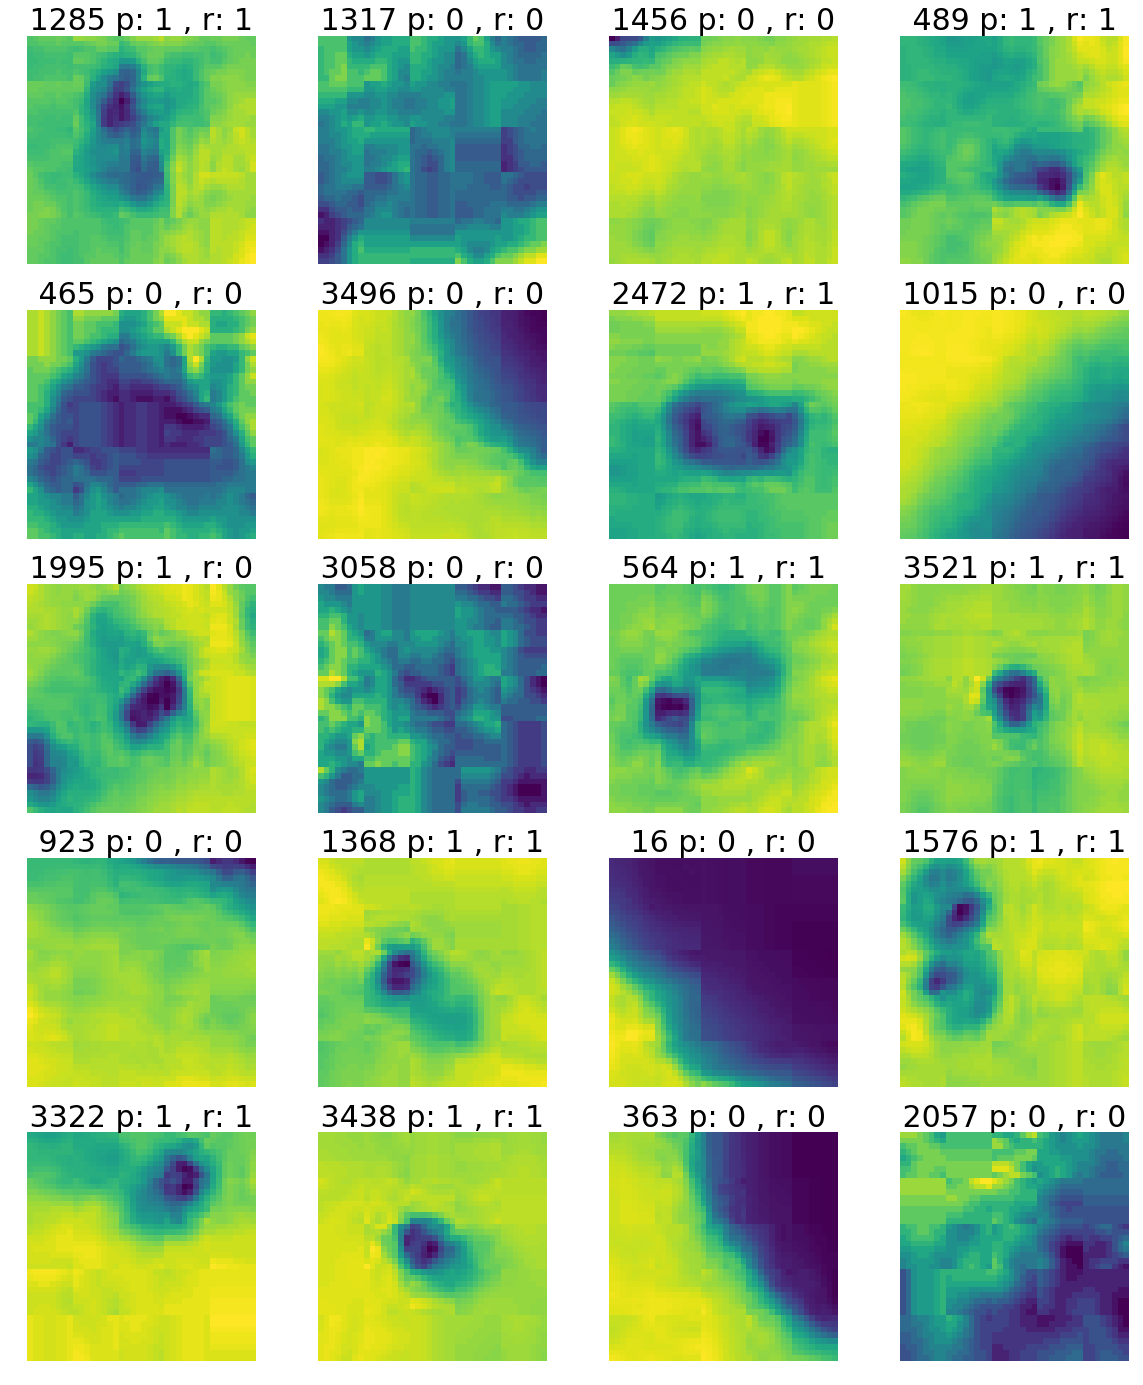



threshold:  0.0 Accuraccy: 0.50275786
True possitive:  1823   True negative:    0
False negative:  0      False possitive:  1803
Sensitivity:  1.0 Specificity:  0.0
F1: 0.6691135988254726
Total:  3626


threshold:  0.005 Accuraccy: 0.92608935
True possitive:  1819   True negative:    1539
False negative:  4      False possitive:  264
Sensitivity:  0.998 Specificity:  0.854
F1: 0.9313876088069637
Total:  3626


threshold:  0.01 Accuraccy: 0.93960287
True possitive:  1818   True negative:    1589
False negative:  5      False possitive:  214
Sensitivity:  0.997 Specificity:  0.881
F1: 0.9431906614785992
Total:  3626


threshold:  0.015 Accuraccy: 0.94815223
True possitive:  1817   True negative:    1621
False negative:  6      False possitive:  182
Sensitivity:  0.997 Specificity:  0.899
F1: 0.9508110936682366
Total:  3626


threshold:  0.02 Accuraccy: 0.95256481
True possitive:  1817   True negative:    1637
False negative:  6      False possitive:  166
Sensitivity:  0.997 Specificity



threshold:  0.24 Accuraccy: 0.97793712
True possitive:  1806   True negative:    1740
False negative:  17      False possitive:  63
Sensitivity:  0.991 Specificity:  0.965
F1: 0.9783315276273022
Total:  3626


threshold:  0.245 Accuraccy: 0.97793712
True possitive:  1806   True negative:    1740
False negative:  17      False possitive:  63
Sensitivity:  0.991 Specificity:  0.965
F1: 0.9783315276273022
Total:  3626


threshold:  0.25 Accuraccy: 0.97821291
True possitive:  1806   True negative:    1741
False negative:  17      False possitive:  62
Sensitivity:  0.991 Specificity:  0.966
F1: 0.978596586290978
Total:  3626


threshold:  0.255 Accuraccy: 0.97876448
True possitive:  1806   True negative:    1743
False negative:  17      False possitive:  60
Sensitivity:  0.991 Specificity:  0.967
F1: 0.9791271347248577
Total:  3626


threshold:  0.26 Accuraccy: 0.97904026
True possitive:  1806   True negative:    1744
False negative:  17      False possitive:  59
Sensitivity:  0.991 Speci



threshold:  0.475 Accuraccy: 0.98124655
True possitive:  1794   True negative:    1764
False negative:  29      False possitive:  39
Sensitivity:  0.984 Specificity:  0.978
F1: 0.9814004376367614
Total:  3626


threshold:  0.48 Accuraccy: 0.98152234
True possitive:  1794   True negative:    1765
False negative:  29      False possitive:  38
Sensitivity:  0.984 Specificity:  0.979
F1: 0.9816689466484269
Total:  3626


threshold:  0.485 Accuraccy: 0.98179812
True possitive:  1794   True negative:    1766
False negative:  29      False possitive:  37
Sensitivity:  0.984 Specificity:  0.979
F1: 0.9819376026272578
Total:  3626


threshold:  0.49 Accuraccy: 0.98152234
True possitive:  1793   True negative:    1766
False negative:  30      False possitive:  37
Sensitivity:  0.984 Specificity:  0.979
F1: 0.9816589104845332
Total:  3626


threshold:  0.495 Accuraccy: 0.98179812
True possitive:  1793   True negative:    1767
False negative:  30      False possitive:  36
Sensitivity:  0.984 Spe


threshold:  0.695 Accuraccy: 0.97848869
True possitive:  1777   True negative:    1771
False negative:  46      False possitive:  32
Sensitivity:  0.975 Specificity:  0.982
F1: 0.9785242290748899
Total:  3626


threshold:  0.7 Accuraccy: 0.97821291
True possitive:  1776   True negative:    1771
False negative:  47      False possitive:  32
Sensitivity:  0.974 Specificity:  0.982
F1: 0.9782429082897274
Total:  3626


threshold:  0.705 Accuraccy: 0.97821291
True possitive:  1776   True negative:    1771
False negative:  47      False possitive:  32
Sensitivity:  0.974 Specificity:  0.982
F1: 0.9782429082897274
Total:  3626


threshold:  0.71 Accuraccy: 0.97821291
True possitive:  1776   True negative:    1771
False negative:  47      False possitive:  32
Sensitivity:  0.974 Specificity:  0.982
F1: 0.9782429082897274
Total:  3626


threshold:  0.715 Accuraccy: 0.97848869
True possitive:  1776   True negative:    1772
False negative:  47      False possitive:  31
Sensitivity:  0.974 Speci



threshold:  0.935 Accuraccy: 0.96883618
True possitive:  1728   True negative:    1785
False negative:  95      False possitive:  18
Sensitivity:  0.948 Specificity:  0.99
F1: 0.9683384701597086
Total:  3626


threshold:  0.94 Accuraccy: 0.96828461
True possitive:  1724   True negative:    1787
False negative:  99      False possitive:  16
Sensitivity:  0.946 Specificity:  0.991
F1: 0.9677238282346338
Total:  3626


threshold:  0.945 Accuraccy: 0.96745725
True possitive:  1721   True negative:    1787
False negative:  102      False possitive:  16
Sensitivity:  0.944 Specificity:  0.991
F1: 0.9668539325842697
Total:  3626


threshold:  0.95 Accuraccy: 0.96690568
True possitive:  1719   True negative:    1787
False negative:  104      False possitive:  16
Sensitivity:  0.943 Specificity:  0.991
F1: 0.9662731871838112
Total:  3626


threshold:  0.955 Accuraccy: 0.96497518
True possitive:  1712   True negative:    1787
False negative:  111      False possitive:  16
Sensitivity:  0.939 S

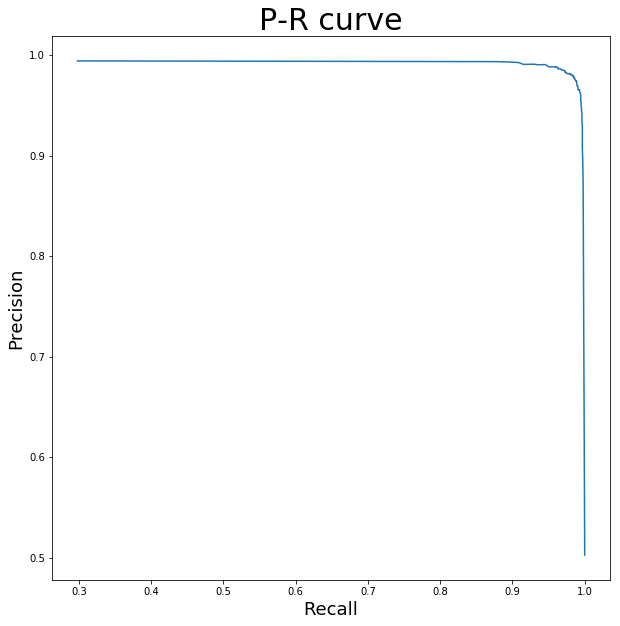

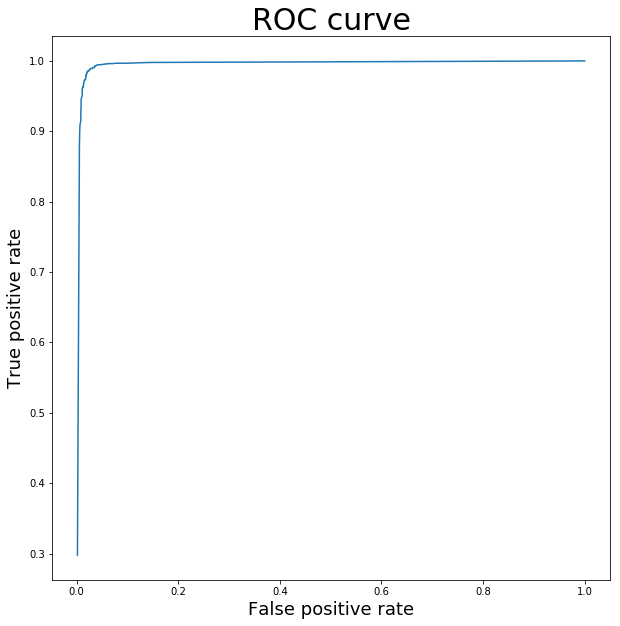

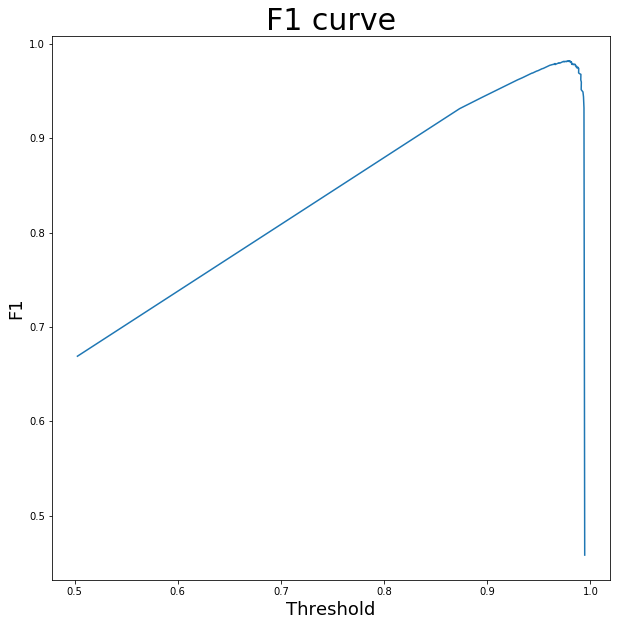

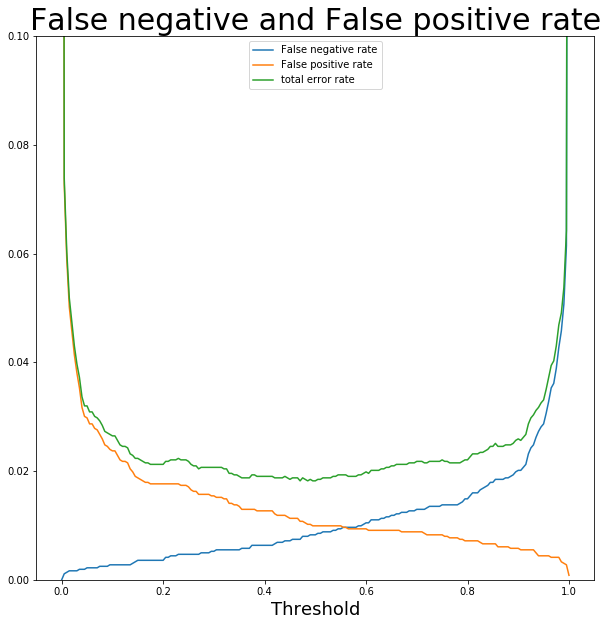

In [6]:
model_test(dir_img_True = '../data pre processing/croped data/malaria/' , 
           dir_img_False = '../data pre processing/croped data/no malaria/' , weights_file = './model_weights.h5' , 
           img_rows = 40 , img_cols = 40, num_images = 20, print_metrics_threshold = True , threshold = 5, 
           plot_figures = True)